# Week 5, Lecture 2: $K$-Nearest Neighbours
MTU Spring 2025

Instructor: Amna Mazen

### Learning outcomes

From this lecture, you will be able to

- explain the notion of similarity-based algorithms;
- broadly describe how $k$-NNs use distances;
- discuss the effect of using a small/large value of the hyperparameter $k$ when using the $k$-NN algorithm;
- describe the problem of curse of dimensionality.

In [3]:
#!pip install ipywidgets

## Import

In [4]:
!pip install mglearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 5.4 MB/s eta 0:00:00


In [15]:
import sys

import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

#sys.path.append("code/.")

import mglearn
from IPython.display import display
#from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate, train_test_split
#from utils import *
from ipywidgets import interact, interactive
import ipywidgets as widgets
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics.pairwise import euclidean_distances
%matplotlib inline

pd.set_option("display.max_colwidth", 200)
import warnings

warnings.filterwarnings("ignore")

## K Nearest Neighbors (KNN)

- It was first introduced in early 1950s
- Nonparametric model
- Instance-based learning
- Lazy learner
- Widely used in pattern classification


### General idea of $k$-nearest neighbours algorithm

- Consider the following toy dataset with two classes.
    - blue circles $\rightarrow$ class 0
    - red triangles $\rightarrow$ class 1
    - green stars $\rightarrow$ test examples

In [6]:
X, y = mglearn.datasets.make_forge()
X_test = np.array([[8.2, 3.66214339], [9.9, 3.2], [11.2, 0.5]])

In [8]:
def plot_train_test_points(X_train, y_train, X_test, class_names=['class 0','class 1'], test_format='star'):
    training_points = mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
    if test_format == "circle":
        test_points = mglearn.discrete_scatter(
                X_test[:, 0], X_test[:, 1], markers="o", c='k', s=18
            );
    else:
        test_points = mglearn.discrete_scatter(
                X_test[:, 0], X_test[:, 1], markers="*", c='g', s=16
            );
    plt.legend(
        training_points + test_points,
        [class_names[0], class_names[1], "test point(s)"],
    )

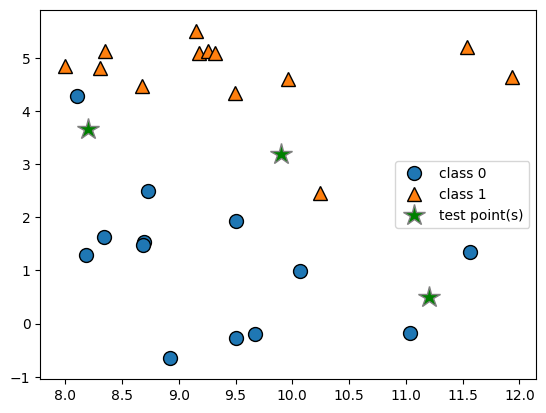

In [9]:
plot_train_test_points(X, y, X_test)

- Given a new data point, predict the class of the data point by finding the "closest" data point in the training set, i.e., by finding its "nearest neighbour" or majority vote of nearest neighbours.

In [10]:
def plot_knn_clf(X_train, y_train, X_test, n_neighbors=1, class_names=['class 0','class 1'], test_format='star'):
    # credit: This function is based on: https://github.com/amueller/mglearn/blob/master/mglearn/plot_knn_classification.py
    plt.clf()
    print('n_neighbors', n_neighbors)
    dist = euclidean_distances(X_train, X_test)
    closest = np.argsort(dist, axis=0)
    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
    plot_train_test_points(X_train, y_train, X_test, class_names, test_format)
    for x, neighbors in zip(X_test, closest.T):
        for neighbor in neighbors[:n_neighbors]:
            plt.arrow(
                x[0],
                x[1],
                X_train[neighbor, 0] - x[0],
                X_train[neighbor, 1] - x[1],
                head_width=0,
                fc="k",
                ec="k",
            )
    plt.show()

In [11]:
def f(n_neighbors):
    return plot_knn_clf(X, y, X_test, n_neighbors=n_neighbors)

In [16]:
interactive(
    f,
    n_neighbors=widgets.IntSlider(min=1, max=10, step=2, value=1),
)

interactive(children=(IntSlider(value=1, description='n_neighbors', max=10, min=1, step=2), Output()), _dom_cl…

## City Example

In [17]:
cities_df = pd.read_csv("https://raw.githubusercontent.com/MazenMTULab/ML_COURSE_RESOURCES/refs/heads/main/Dataset/Lecture_Dataset/canada_usa_cities.csv")
small_cities = cities_df.sample(30, random_state=90)
one_city = small_cities.sample(1, random_state=44)
small_train_df = pd.concat([small_cities, one_city]).drop_duplicates(keep=False)

In [18]:

X_small_cities = small_train_df.drop(columns=["country"]).to_numpy()
y_small_cities = small_train_df["country"].to_numpy()
test_point = one_city[["longitude", "latitude"]].to_numpy()

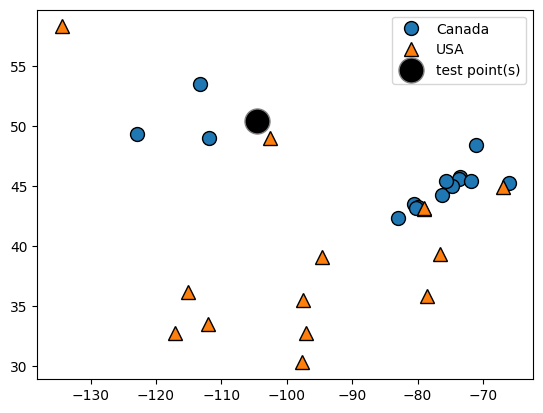

In [19]:
plot_train_test_points(
    X_small_cities,
    y_small_cities,
    test_point,
    class_names=["Canada", "USA"],
    test_format="circle",
)

- Given a new data point, predict the class of the data point by finding the "closest" data point in the training set, i.e., by finding its "nearest neighbour" or majority vote of nearest neighbours.

Suppose we want to predict the class of the black point.  
- An intuitive way to do this is predict the same label as the "closest" point ($k = 1$) (1-nearest neighbour)
- We would predict a target of **USA** in this case.

n_neighbors 1


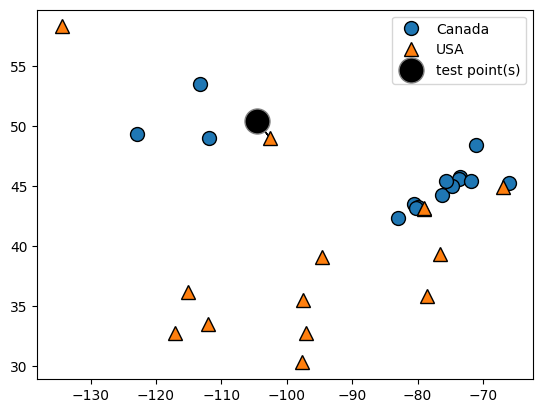

In [20]:

plot_knn_clf(
    X_small_cities,
    y_small_cities,
    test_point,
    n_neighbors=1,
    class_names=["Canada", "USA"],
    test_format="circle",
)

How about using $k > 1$ to get a more robust estimate?
- For example, we could also use the 3 closest points (*k* = 3) and let them **vote** on the correct class.  
- The **Canada** class would win in this case.

n_neighbors 3


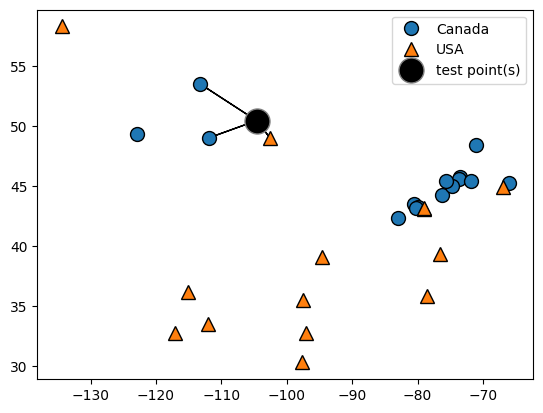

In [21]:
plot_knn_clf(
    X_small_cities,
    y_small_cities,
    test_point,
    n_neighbors=3,
    class_names=["Canada", "USA"],
    test_format="circle",
)

In [22]:
from sklearn.neighbors import KNeighborsClassifier

k_values = [1, 3]

for k in k_values:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_small_cities, y_small_cities)
    print(
        "Prediction of the black dot with %d neighbours: %s"
        % (k, neigh.predict(test_point))
    )

Prediction of the black dot with 1 neighbours: ['USA']
Prediction of the black dot with 3 neighbours: ['Canada']


### Choosing `n_neighbors`

- The primary hyperparameter of the model is `n_neighbors` ($k$) which decides how many neighbours should vote during prediction?
- What happens when we play around with `n_neighbors`?
- Are we more likely to overfit with a low `n_neighbors` or a high `n_neighbors`?
- Let's examine the effect of the hyperparameter on our cities data.

In [23]:
X = cities_df.drop(columns=["country"])
y = cities_df["country"]

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=123
)

In [24]:
k = 1
knn1 = KNeighborsClassifier(n_neighbors=k)
scores = cross_validate(knn1, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.003791,0.005284,0.710526,1.0
1,0.002253,0.004490,0.684211,1.0
2,0.002316,0.004524,0.842105,1.0
3,0.002159,0.004389,0.702703,1.0
4,0.002180,0.004346,0.837838,1.0


In [25]:
k = 100
knn100 = KNeighborsClassifier(n_neighbors=k)
scores = cross_validate(knn100, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.002961,0.052017,0.605263,0.600000
1,0.002117,0.005167,0.605263,0.600000
2,0.002586,0.005344,0.605263,0.600000
3,0.002054,0.005124,0.594595,0.602649
4,0.002121,0.005013,0.594595,0.602649


In [26]:
def f(n_neighbors=1):
    results = {}
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    scores = cross_validate(knn, X_train, y_train, return_train_score=True)
    results["n_neighbours"] = [n_neighbors]
    results["mean_train_score"] = [round(scores["train_score"].mean(), 3)]
    results["mean_valid_score"] = [round(scores["test_score"].mean(), 3)]
    print(pd.DataFrame(results))


interactive(
    f,
    n_neighbors=widgets.IntSlider(min=1, max=101, step=5, value=1),
)

interactive(children=(IntSlider(value=1, description='n_neighbors', max=101, min=1, step=5), Output()), _dom_c…

In [27]:
def plot_knn_decision_boundaries(X_train, y_train, k_values = [1,11,100]):
    fig, axes = plt.subplots(1, len(k_values), figsize=(15, 4))

    for n_neighbors, ax in zip(k_values, axes):
        clf = KNeighborsClassifier(n_neighbors=n_neighbors)
        scores = cross_validate(clf, X_train, y_train, return_train_score=True)
        mean_valid_score = scores["test_score"].mean()
        mean_train_score = scores["train_score"].mean()
        clf.fit(X_train, y_train)
        mglearn.plots.plot_2d_separator(
            clf, X_train.to_numpy(), fill=True, eps=0.5, ax=ax, alpha=0.4
        )
        mglearn.discrete_scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], y_train, ax=ax)
        title = "n_neighbors={}\n train score={}\n valid score={}".format(
            n_neighbors, round(mean_train_score, 2), round(mean_valid_score, 2)
        )
        ax.set_title(title)
        ax.set_xlabel("longitude")
        ax.set_ylabel("latitude")
    axes[0].legend(loc=1);

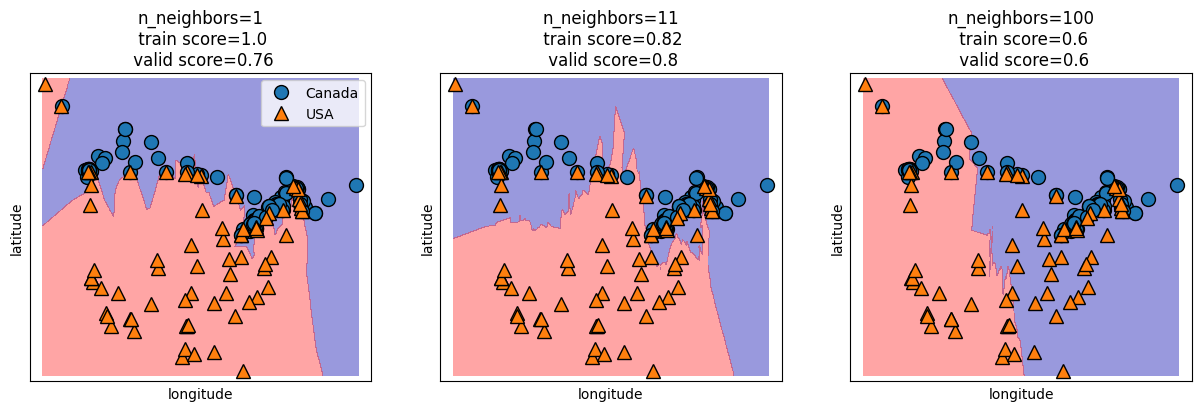

In [28]:
plot_knn_decision_boundaries(X_train, y_train, k_values=[1, 11, 100])

### How to choose `n_neighbors`?

- `n_neighbors` is a hyperparameter
- We can use hyperparameter optimization to choose `n_neighbors`.

In [29]:
results_dict = {
    "n_neighbors": [],
    "mean_train_score": [],
    "mean_cv_score": [],
    "std_cv_score": [],
    "std_train_score": [],
}
param_grid = {"n_neighbors": np.arange(1, 50, 5)}

for k in param_grid["n_neighbors"]:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_validate(knn, X_train, y_train, return_train_score=True)
    results_dict["n_neighbors"].append(k)

    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))
    results_dict["std_cv_score"].append(scores["test_score"].std())
    results_dict["std_train_score"].append(scores["train_score"].std())

results_df = pd.DataFrame(results_dict)

In [30]:
results_df = results_df.set_index("n_neighbors")
results_df

,mean_train_score,mean_cv_score,std_cv_score,std_train_score
n_neighbors,,,,
1,1.000000,0.755477,0.069530,0.000000
6,0.831135,0.792603,0.046020,0.013433
11,0.819152,0.802987,0.041129,0.011336
16,0.801863,0.782219,0.074141,0.008735
21,0.777934,0.766430,0.062792,0.016944
26,0.755364,0.723613,0.061937,0.025910
31,0.743391,0.707681,0.057646,0.030408
36,0.728777,0.707681,0.064452,0.021305
41,0.706128,0.681223,0.061241,0.018310


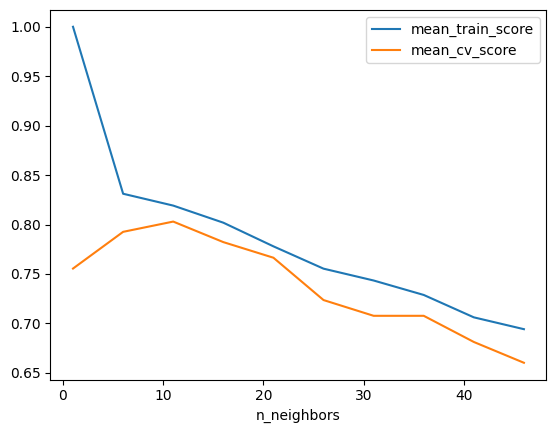

In [31]:
results_df[["mean_train_score", "mean_cv_score"]].plot();

In [32]:
best_n_neighbours = results_df.idxmax()["mean_cv_score"]
best_n_neighbours

11

Let's try our best model on test data.

In [33]:
knn = KNeighborsClassifier(n_neighbors=best_n_neighbours)
knn.fit(X_train, y_train)
print("Test accuracy: %0.3f" % (knn.score(X_test, y_test)))

Test accuracy: 0.905


Looking good!

## Iris dataset

In [34]:
# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

# Loading data
irisData = load_iris()

In [35]:
# Names of features/columns in iris dataset
print(irisData.feature_names)





['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [36]:
# Names of target/output in iris dataset
print(irisData.target_names)


['setosa' 'versicolor' 'virginica']


In [37]:
# Store features matrix in X
X= irisData.data
#Store target vector in
y= irisData.target

#let's print features
print(X)


[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.9 3.1 4.

In [38]:
# print target vector : # iris species: 0 = setosa, 1 = versicolor, 2 = virginica
print(y)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


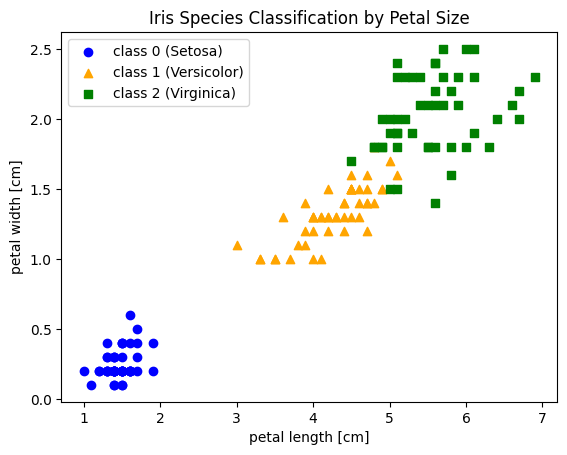

In [39]:
# Define markers for each species
markers = ['o', '^', 's']

# Define colors for each species
colors = ['blue', 'orange', 'green']

# Names of the species
species = ['Setosa', 'Versicolor', 'Virginica']

# Plot each species
for i in range(len(species)):
    # Extract the indices for which the target is equal to the species number (i)
    xs = X[:, 2][y == i]  # Petal length is the third feature
    ys = X[:, 3][y == i]  # Petal width is the fourth feature
    plt.scatter(xs, ys, c=colors[i], marker=markers[i], label=f'class {i} ({species[i]})')

# Customize the plot
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.title('Iris Species Classification by Petal Size')
plt.legend(loc='upper left')

# Display the plot
plt.show()

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.5, random_state=42)


In [41]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# train accuracy
print(knn.predict(X_test))

[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0 1 1 2 1 2 1 2 1 0 2 1 0 0 0 1 1 0 0 0 1 0 1 2 0 1 2 0 2 2
 1]


In [42]:
print(knn.score(X_test, y_test))


0.9733333333333334


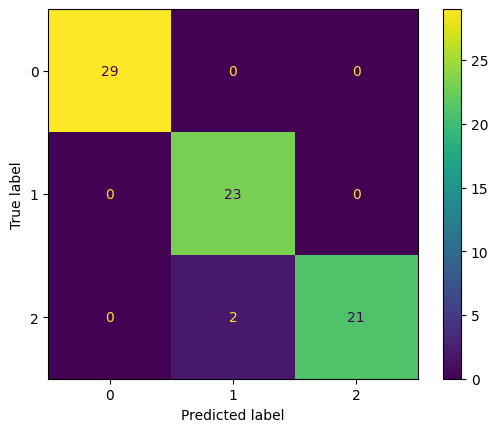

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred=knn.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(cm, display_labels=knn.classes_)
disp.plot()
plt.show()

In [ ]:
#!pip install mlxtend

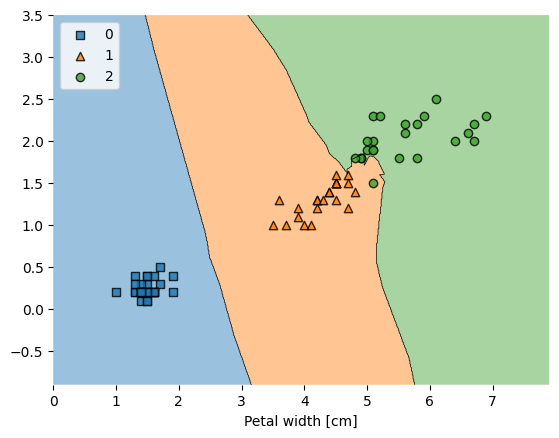

In [44]:
from mlxtend.plotting import plot_decision_regions

X_train, X_test, y_train, y_test = train_test_split(
             X[:,2:], y, test_size = 0.5, random_state=42)

knn_=KNeighborsClassifier(n_neighbors=3)
knn_.fit(X_train, y_train)

plot_decision_regions(X_test, y_test, knn_)
plt.xlabel('Petal length [cm]')
plt.xlabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.show()

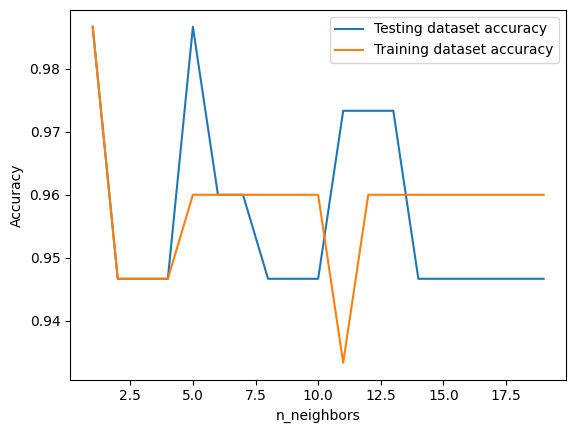

In [45]:
## Trying different k values

k_values=np.arange(1,20)
tr_acc=np.empty(len(k_values))
ts_acc=np.empty(len(k_values))

for i, k in enumerate(k_values):
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    tr_acc[i]=knn.score(X_train, y_train)
    ts_acc[i]=knn.score(X_test, y_test)


plt.plot(k_values, ts_acc, label='Testing dataset accuracy')
plt.plot(k_values, tr_acc, label='Training dataset accuracy')

plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()


### Using feature scaling

In [ ]:
##Using feature scaling
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.5, random_state=42)

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# test accuracy
print(knn.score(X_test, y_test))


0.9866666666666667


## Distance-Weighted KNN

### Other useful arguments of `KNeighborsClassifier`

- `weights` $\rightarrow$ When predicting label, you can assign higher weight to the examples which are closer to the query example.  
- Exercise for you: Play around with this argument. Do you get a better validation score?

### Regression with $k$-nearest neighbours ($k$-NNs)

- Can we solve regression problems with $k$-nearest neighbours algorithm?
- In $k$-NN regression we take the average of the $k$-nearest neighbours.
- We can also have weighted regression.

See an example of regression in the lecture notes.

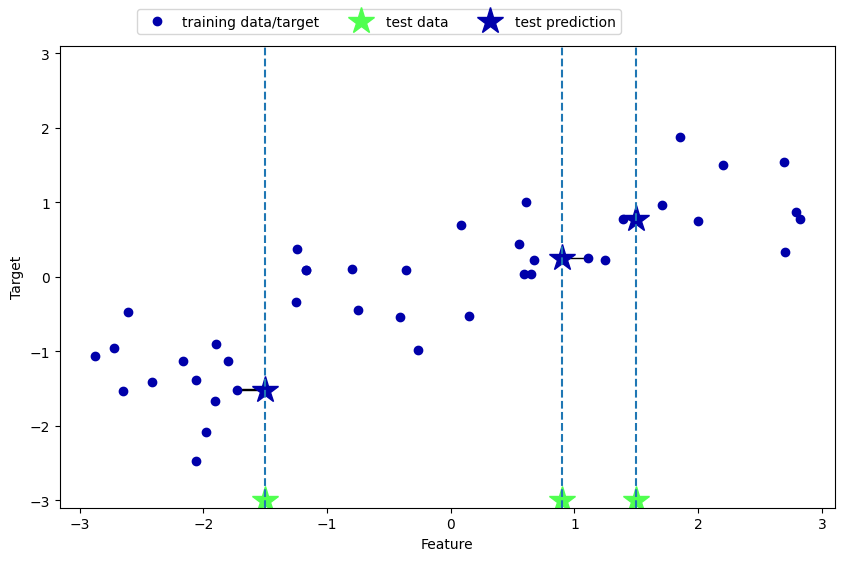

In [ ]:
mglearn.plots.plot_knn_regression(n_neighbors=1)

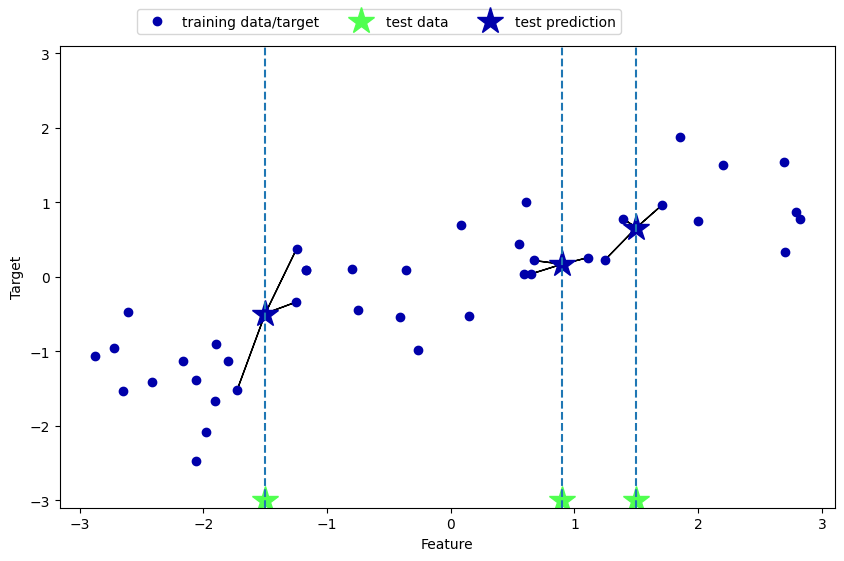

In [ ]:
mglearn.plots.plot_knn_regression(n_neighbors=3)

### Pros of $k$-NNs for supervised learning

- Easy to understand, interpret.
- Simple hyperparameter $k$ (`n_neighbors`) controlling the fundamental tradeoff.
- Can learn very complex functions given enough data.
- Lazy learning: Takes no time to `fit`

### Cons of $k$-NNs for supervised learning

- Can be potentially be VERY slow during prediction time, especially when the training set is very large.
- Often not that great test accuracy compared to the modern approaches.
- It does not work well on datasets with many features or where most feature values are 0 most of the time (sparse datasets).    